### Import Packages


In [ ]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

1.13.0+cu116


### MNIST dataset is provided in default

In [ ]:
train_path = './sample_data/mnist_train_small.csv'
test_path = './sample_data/mnist_test.csv'
img_size = 28

### Choose your device - use GPU or not?

In [ ]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Read the MNIST dataset
- total 1+ 28x28 dimension. 1 For Label, 28**2 for image


In [ ]:
def mnist_reader(file_path, img_size=img_size):
    total_img = list()
    total_label = list()
    with open(file_path) as csvfile:
        mnist_reader = csv.reader(csvfile)
        for row in tqdm(mnist_reader):
            img = np.array(row[1:], dtype=np.uint16).reshape(img_size, img_size)
            # pixel range : -1 ~ 1 (differ from VAE, which has 0 ~ 1)
            img = (img / 255) * 2 - 1
            label = int(row[0])

            total_img.append(img)
            total_label.append(label)

    total_img = np.asarray(total_img)
    total_label = np.asarray(total_label)
    
    return total_img, total_label

In [ ]:
train_img, train_label = mnist_reader(train_path)
test_img, test_label = mnist_reader(test_path)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Define the Dataset

In [ ]:
class MNIST_Dataset(Dataset):
    def __init__(self, target_img, target_label):
        self.target_img = target_img
        self.target_label = target_label
        self.num_data = target_img.shape[0]

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        sample = dict()
        sample['img'] = self.target_img[idx]
        sample['label'] = self.target_label[idx]

        return sample

### Define the DataLoader

In [ ]:
batch_size = 64

train_dataset = MNIST_Dataset(train_img, train_label)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Try to sample out one data point from dataloader

In [ ]:
sample = next(iter(train_dataloader))
print(sample['img'].shape)
print(sample['label'].shape)

torch.Size([64, 28, 28])
torch.Size([64])


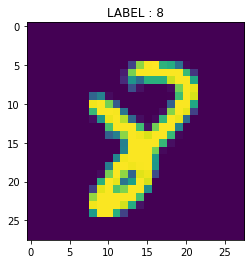

In [ ]:
plot_idx = 0
plt.imshow(sample['img'][plot_idx])
plt.title('LABEL : {}'.format(sample['label'][plot_idx]))
plt.show()

### Define the GAN (Generator + Discriminator)


In [ ]:
class Generator(nn.Module): # latent feature -> image
    def __init__(self, dim_hidden_1, dim_hidden_2, dim_z, dim_input=img_size**2):
        super(Generator, self).__init__()
        
        # define hidden dimension
        self.dim_hidden_1 = dim_hidden_1
        self.dim_hidden_2 = dim_hidden_2
        self.dim_z = dim_z
        self.dim_input = dim_input

        # define generator : dim_z -> dim_input
        self.fc_1 = nn.Linear(dim_z, dim_hidden_1)
        self.fc_2 = nn.Linear(dim_hidden_1, dim_hidden_2)
        self.fc_3 = nn.Linear(dim_hidden_2, dim_input)

        self.bn_1 = nn.BatchNorm1d(dim_hidden_1)
        self.bn_2 = nn.BatchNorm1d(dim_hidden_2)
    
        self.activation = nn.LeakyReLU(0.2)
    
    def forward(self, z):
        out = self.activation(self.bn_1(self.fc_1(z)))
        out = self.activation(self.bn_2(self.fc_2(out)))
        out = torch.tanh(self.fc_3(out)) # because range of input data value : -1 ~ 1
        
        return out

class Discriminator(nn.Module): # image -> scalar(fake or not)
    def __init__(self, dim_hidden_1, dim_hidden_2, dim_input=img_size**2):
        super(Discriminator, self).__init__()

        # define hidden dimension
        self.dim_hidden_1 = dim_hidden_1
        self.dim_hidden_2 = dim_hidden_2
        self.dim_input = dim_input

        # define discriminator : dim_input -> scalar(dim=1)
        self.fc_1 = nn.Linear(dim_input, dim_hidden_1)
        self.fc_2 = nn.Linear(dim_hidden_1, dim_hidden_2)
        self.fc_3 = nn.Linear(dim_hidden_2, 1)

        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        # x needs to be flatted into B by D
        # x : B * D
        out = self.activation(self.fc_1(x))
        out = self.activation(self.fc_2(out))
        out = self.fc_3(out) # B * 1

        return torch.sigmoid(out).squeeze(1) # squeeze(1) : eliminates '1' in the shape (B, 1) -> (B,)


### Define the Model

In [ ]:
dim_hidden_1 = 256
dim_hidden_2 = 512
dim_z = 128
generator = Generator(dim_hidden_1, dim_hidden_2, dim_z).to(device)
discriminator = Discriminator(dim_hidden_1, dim_hidden_2).to(device)

# individual optimzer is used for generator and discriminator
gen_optimizer = optim.Adam(generator.parameters(), lr=2e-5, betas=(0.5, 0.999)) # lr, beta -> imperically found
dis_optimizer = optim.Adam(discriminator.parameters(), lr=2e-5, betas=(0.5, 0.999)) # lr, beta -> impericall found

print(generator)
print(discriminator)

Generator(
  (fc_1): Linear(in_features=128, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=512, bias=True)
  (fc_3): Linear(in_features=512, out_features=784, bias=True)
  (bn_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.2)
)
Discriminator(
  (fc_1): Linear(in_features=784, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=512, bias=True)
  (fc_3): Linear(in_features=512, out_features=1, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
)


### Define functions for train/test

In [ ]:
def train(generator, discriminator, gen_optimizer, dis_optimizer, dim_z, sample):
    # sample['img'] : B * 28 * 28
    batch_size = sample['img'].shape[0] # B

    # BCELoss Function : x log(x') + (1 - x) log(1-x') {x: gt, x': pred}
    criterion = nn.BCELoss()
    real_label = torch.ones(batch_size).to(device) # (B * 1)
    fake_label = torch.zeros(batch_size).to(device) # (B * 1)

    sample_z = torch.randn(batch_size, dim_z).to(device)
    real_img = sample['img'].float().to(device).view(batch_size, -1)
    fake_img = generator(sample_z)

    # Train Generator : to make discriminator won't discriminate fake and real
    generator.train()
    gen_optimizer.zero_grad()

    g_loss = criterion(discriminator(fake_img), real_label) # loss of generator : given fake image, generator wants discriminator to output 1

    g_loss.backward()
    gen_optimizer.step()
    
    # Train Discriminator
    discriminator.train()
    dis_optimizer.zero_grad()

    real_loss = criterion(discriminator(real_img), real_label) # when given real img, it should return 1
    fake_loss = criterion(discriminator(fake_img.detach()), fake_label) # when given fake img, it should return 0
    # detach : to eliminate backpropagation effect
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    dis_optimizer.step()    

    return g_loss.item(), d_loss.item()    
    

In [ ]:
def test(generator, img_size, dim_z):
    generator.eval()
    with torch.no_grad():
        sample_z = torch.randn(1, dim_z).to(device)
        fake_data = generator(sample_z.to(device))

    return 0.5*(fake_data.view(img_size, img_size).detach().cpu().numpy() + 1)

### Run Training
* Two loss values should be balanced

  0%|          | 0/200 [00:00<?, ?it/s]

[EPOCH 0] SAMPLED G LOSS : 0.6884456276893616, SAMPLED D LOSS : 0.6792386770248413
[EPOCH 0] SAMPLED G LOSS : 0.5457667708396912, SAMPLED D LOSS : 0.5467110872268677


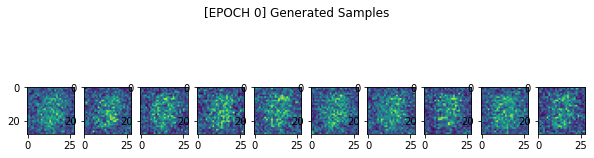

[EPOCH 1] SAMPLED G LOSS : 0.527759850025177, SAMPLED D LOSS : 0.6143999695777893
[EPOCH 1] SAMPLED G LOSS : 0.5797522664070129, SAMPLED D LOSS : 0.637795090675354
[EPOCH 2] SAMPLED G LOSS : 0.6129888296127319, SAMPLED D LOSS : 0.6340628862380981
[EPOCH 2] SAMPLED G LOSS : 0.6725478172302246, SAMPLED D LOSS : 0.6013661623001099
[EPOCH 3] SAMPLED G LOSS : 0.677422821521759, SAMPLED D LOSS : 0.607020378112793
[EPOCH 3] SAMPLED G LOSS : 0.710159420967102, SAMPLED D LOSS : 0.5730743408203125
[EPOCH 4] SAMPLED G LOSS : 0.7000096440315247, SAMPLED D LOSS : 0.546650767326355
[EPOCH 4] SAMPLED G LOSS : 0.7407357096672058, SAMPLED D LOSS : 0.5458802580833435
[EPOCH 5] SAMPLED G LOSS : 0.8027355670928955, SAMPLED D LOSS : 0.5387428998947144
[EPOCH 5] SAMPLED G LOSS : 0.7784304618835449, SAMPLED D LOSS : 0.5255929827690125
[EPOCH 6] SAMPLED G LOSS : 0.8178105354309082, SAMPLED D LOSS : 0.5094810724258423
[EPOCH 6] SAMPLED G LOSS : 0.7728797197341919, SAMPLED D LOSS : 0.5153579115867615
[EPOCH 7] 

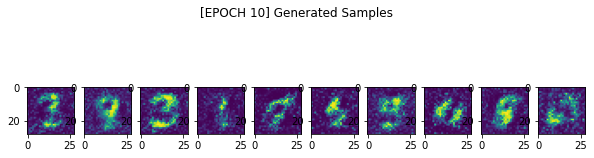

[EPOCH 11] SAMPLED G LOSS : 1.0122523307800293, SAMPLED D LOSS : 0.41488128900527954
[EPOCH 11] SAMPLED G LOSS : 0.9530726671218872, SAMPLED D LOSS : 0.4504013955593109
[EPOCH 12] SAMPLED G LOSS : 1.0140161514282227, SAMPLED D LOSS : 0.4445178806781769
[EPOCH 12] SAMPLED G LOSS : 0.9394010901451111, SAMPLED D LOSS : 0.4307996928691864
[EPOCH 13] SAMPLED G LOSS : 1.1717205047607422, SAMPLED D LOSS : 0.4276701807975769
[EPOCH 13] SAMPLED G LOSS : 1.2089133262634277, SAMPLED D LOSS : 0.3822023868560791
[EPOCH 14] SAMPLED G LOSS : 1.171034812927246, SAMPLED D LOSS : 0.4126686453819275
[EPOCH 14] SAMPLED G LOSS : 1.220337152481079, SAMPLED D LOSS : 0.4012119770050049
[EPOCH 15] SAMPLED G LOSS : 1.056882381439209, SAMPLED D LOSS : 0.39932623505592346
[EPOCH 15] SAMPLED G LOSS : 1.3438137769699097, SAMPLED D LOSS : 0.3895760178565979
[EPOCH 16] SAMPLED G LOSS : 1.1926292181015015, SAMPLED D LOSS : 0.40020787715911865
[EPOCH 16] SAMPLED G LOSS : 0.9715921878814697, SAMPLED D LOSS : 0.402422070

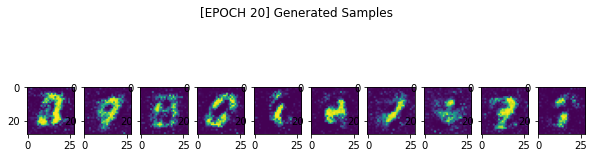

[EPOCH 21] SAMPLED G LOSS : 1.0588815212249756, SAMPLED D LOSS : 0.4680277705192566
[EPOCH 21] SAMPLED G LOSS : 1.2687532901763916, SAMPLED D LOSS : 0.4780605435371399
[EPOCH 22] SAMPLED G LOSS : 1.042921781539917, SAMPLED D LOSS : 0.4623425602912903
[EPOCH 22] SAMPLED G LOSS : 1.285301685333252, SAMPLED D LOSS : 0.4436502158641815
[EPOCH 23] SAMPLED G LOSS : 1.1302958726882935, SAMPLED D LOSS : 0.4539426267147064
[EPOCH 23] SAMPLED G LOSS : 1.1935844421386719, SAMPLED D LOSS : 0.4715976417064667
[EPOCH 24] SAMPLED G LOSS : 1.208463191986084, SAMPLED D LOSS : 0.45121318101882935
[EPOCH 24] SAMPLED G LOSS : 0.8533443212509155, SAMPLED D LOSS : 0.4773741066455841
[EPOCH 25] SAMPLED G LOSS : 1.1689448356628418, SAMPLED D LOSS : 0.46254801750183105
[EPOCH 25] SAMPLED G LOSS : 0.9348675012588501, SAMPLED D LOSS : 0.5103016495704651
[EPOCH 26] SAMPLED G LOSS : 1.2040804624557495, SAMPLED D LOSS : 0.47699326276779175
[EPOCH 26] SAMPLED G LOSS : 1.2397019863128662, SAMPLED D LOSS : 0.470778763

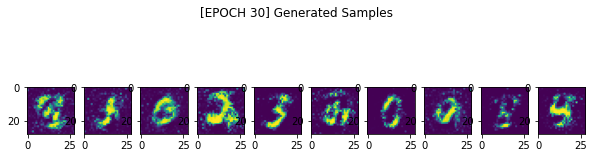

[EPOCH 31] SAMPLED G LOSS : 0.9747053384780884, SAMPLED D LOSS : 0.4837159812450409
[EPOCH 31] SAMPLED G LOSS : 1.3357036113739014, SAMPLED D LOSS : 0.4699456989765167
[EPOCH 32] SAMPLED G LOSS : 1.1615259647369385, SAMPLED D LOSS : 0.4287518858909607
[EPOCH 32] SAMPLED G LOSS : 1.212540864944458, SAMPLED D LOSS : 0.4129962921142578
[EPOCH 33] SAMPLED G LOSS : 1.1681283712387085, SAMPLED D LOSS : 0.45153385400772095
[EPOCH 33] SAMPLED G LOSS : 0.8583579063415527, SAMPLED D LOSS : 0.5102702379226685
[EPOCH 34] SAMPLED G LOSS : 1.134739875793457, SAMPLED D LOSS : 0.4970259368419647
[EPOCH 34] SAMPLED G LOSS : 1.1479167938232422, SAMPLED D LOSS : 0.4688883423805237
[EPOCH 35] SAMPLED G LOSS : 0.8343700170516968, SAMPLED D LOSS : 0.46689102053642273
[EPOCH 35] SAMPLED G LOSS : 1.4194310903549194, SAMPLED D LOSS : 0.46369248628616333
[EPOCH 36] SAMPLED G LOSS : 0.6392641067504883, SAMPLED D LOSS : 0.6039667725563049
[EPOCH 36] SAMPLED G LOSS : 0.783362090587616, SAMPLED D LOSS : 0.496560990

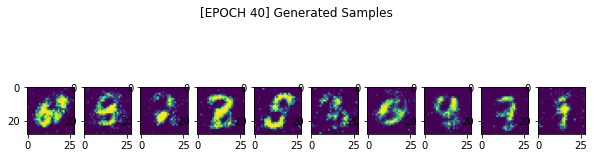

[EPOCH 41] SAMPLED G LOSS : 0.8175101280212402, SAMPLED D LOSS : 0.5392741560935974
[EPOCH 41] SAMPLED G LOSS : 0.9075067043304443, SAMPLED D LOSS : 0.5310678482055664
[EPOCH 42] SAMPLED G LOSS : 1.1372449398040771, SAMPLED D LOSS : 0.5100760459899902
[EPOCH 42] SAMPLED G LOSS : 1.2694625854492188, SAMPLED D LOSS : 0.46822142601013184
[EPOCH 43] SAMPLED G LOSS : 0.8209564685821533, SAMPLED D LOSS : 0.5444010496139526
[EPOCH 43] SAMPLED G LOSS : 0.6608849167823792, SAMPLED D LOSS : 0.5657397508621216
[EPOCH 44] SAMPLED G LOSS : 0.821043848991394, SAMPLED D LOSS : 0.5468801259994507
[EPOCH 44] SAMPLED G LOSS : 1.3486425876617432, SAMPLED D LOSS : 0.48929548263549805
[EPOCH 45] SAMPLED G LOSS : 1.1731243133544922, SAMPLED D LOSS : 0.4850897192955017
[EPOCH 45] SAMPLED G LOSS : 1.2550950050354004, SAMPLED D LOSS : 0.5130584836006165
[EPOCH 46] SAMPLED G LOSS : 0.8449302911758423, SAMPLED D LOSS : 0.5790420174598694
[EPOCH 46] SAMPLED G LOSS : 0.7968723773956299, SAMPLED D LOSS : 0.52181482

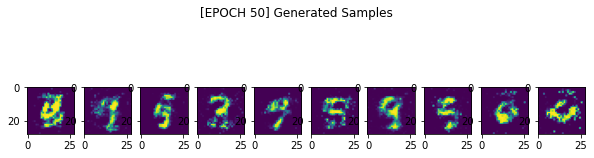

[EPOCH 51] SAMPLED G LOSS : 0.927842378616333, SAMPLED D LOSS : 0.48510053753852844
[EPOCH 51] SAMPLED G LOSS : 0.9509555101394653, SAMPLED D LOSS : 0.5147924423217773
[EPOCH 52] SAMPLED G LOSS : 1.3468533754348755, SAMPLED D LOSS : 0.552948534488678
[EPOCH 52] SAMPLED G LOSS : 0.9946396350860596, SAMPLED D LOSS : 0.503505289554596
[EPOCH 53] SAMPLED G LOSS : 1.2095577716827393, SAMPLED D LOSS : 0.4428377151489258
[EPOCH 53] SAMPLED G LOSS : 1.5778920650482178, SAMPLED D LOSS : 0.48896706104278564
[EPOCH 54] SAMPLED G LOSS : 1.474055528640747, SAMPLED D LOSS : 0.5509805679321289
[EPOCH 54] SAMPLED G LOSS : 0.9231102466583252, SAMPLED D LOSS : 0.4547630548477173
[EPOCH 55] SAMPLED G LOSS : 1.7108280658721924, SAMPLED D LOSS : 0.5194509029388428
[EPOCH 55] SAMPLED G LOSS : 1.0315446853637695, SAMPLED D LOSS : 0.4628145098686218
[EPOCH 56] SAMPLED G LOSS : 1.1193214654922485, SAMPLED D LOSS : 0.5033320784568787
[EPOCH 56] SAMPLED G LOSS : 1.0054652690887451, SAMPLED D LOSS : 0.46503654122

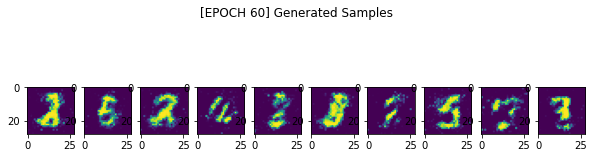

[EPOCH 61] SAMPLED G LOSS : 1.1181601285934448, SAMPLED D LOSS : 0.48972171545028687
[EPOCH 61] SAMPLED G LOSS : 0.757856547832489, SAMPLED D LOSS : 0.5247101783752441
[EPOCH 62] SAMPLED G LOSS : 1.256697654724121, SAMPLED D LOSS : 0.5058556199073792
[EPOCH 62] SAMPLED G LOSS : 0.8601347208023071, SAMPLED D LOSS : 0.5216290950775146
[EPOCH 63] SAMPLED G LOSS : 0.9271150827407837, SAMPLED D LOSS : 0.49389541149139404
[EPOCH 63] SAMPLED G LOSS : 0.8573457598686218, SAMPLED D LOSS : 0.4835991859436035
[EPOCH 64] SAMPLED G LOSS : 0.8292785882949829, SAMPLED D LOSS : 0.5215638279914856
[EPOCH 64] SAMPLED G LOSS : 1.032185673713684, SAMPLED D LOSS : 0.5048860311508179
[EPOCH 65] SAMPLED G LOSS : 1.1050209999084473, SAMPLED D LOSS : 0.5014521479606628
[EPOCH 65] SAMPLED G LOSS : 0.7555537223815918, SAMPLED D LOSS : 0.5289108157157898
[EPOCH 66] SAMPLED G LOSS : 1.1735777854919434, SAMPLED D LOSS : 0.4904078245162964
[EPOCH 66] SAMPLED G LOSS : 1.0875523090362549, SAMPLED D LOSS : 0.4777165055

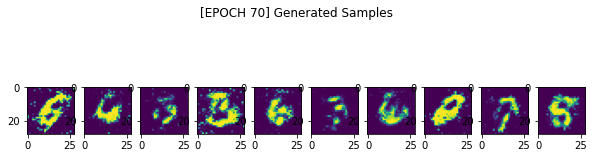

[EPOCH 71] SAMPLED G LOSS : 0.9725835919380188, SAMPLED D LOSS : 0.48080411553382874
[EPOCH 71] SAMPLED G LOSS : 0.8994347453117371, SAMPLED D LOSS : 0.5484983921051025
[EPOCH 72] SAMPLED G LOSS : 1.0402228832244873, SAMPLED D LOSS : 0.4753682017326355
[EPOCH 72] SAMPLED G LOSS : 1.3293945789337158, SAMPLED D LOSS : 0.5528886914253235
[EPOCH 73] SAMPLED G LOSS : 1.2563247680664062, SAMPLED D LOSS : 0.5116850137710571
[EPOCH 73] SAMPLED G LOSS : 1.376997947692871, SAMPLED D LOSS : 0.5055623054504395
[EPOCH 74] SAMPLED G LOSS : 1.126953363418579, SAMPLED D LOSS : 0.5166529417037964
[EPOCH 74] SAMPLED G LOSS : 0.8703227639198303, SAMPLED D LOSS : 0.5247139930725098
[EPOCH 75] SAMPLED G LOSS : 1.1256978511810303, SAMPLED D LOSS : 0.49973544478416443
[EPOCH 75] SAMPLED G LOSS : 0.9441017508506775, SAMPLED D LOSS : 0.5244981646537781
[EPOCH 76] SAMPLED G LOSS : 1.0677382946014404, SAMPLED D LOSS : 0.5781000256538391
[EPOCH 76] SAMPLED G LOSS : 1.0444880723953247, SAMPLED D LOSS : 0.544035732

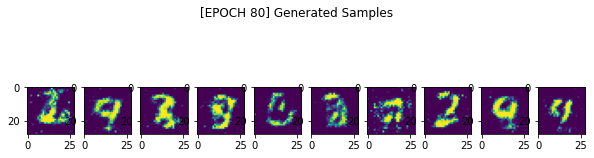

[EPOCH 81] SAMPLED G LOSS : 1.1094744205474854, SAMPLED D LOSS : 0.5191769599914551
[EPOCH 81] SAMPLED G LOSS : 0.9457296133041382, SAMPLED D LOSS : 0.4682600796222687
[EPOCH 82] SAMPLED G LOSS : 1.025195598602295, SAMPLED D LOSS : 0.4714541435241699
[EPOCH 82] SAMPLED G LOSS : 1.5431842803955078, SAMPLED D LOSS : 0.5207979679107666
[EPOCH 83] SAMPLED G LOSS : 1.2767465114593506, SAMPLED D LOSS : 0.5531786680221558
[EPOCH 83] SAMPLED G LOSS : 0.9448379874229431, SAMPLED D LOSS : 0.5299715399742126
[EPOCH 84] SAMPLED G LOSS : 0.7462633848190308, SAMPLED D LOSS : 0.5169526934623718
[EPOCH 84] SAMPLED G LOSS : 1.1540035009384155, SAMPLED D LOSS : 0.4782249331474304
[EPOCH 85] SAMPLED G LOSS : 0.6585919857025146, SAMPLED D LOSS : 0.5407782793045044
[EPOCH 85] SAMPLED G LOSS : 0.9838724136352539, SAMPLED D LOSS : 0.4595493674278259
[EPOCH 86] SAMPLED G LOSS : 0.8315246105194092, SAMPLED D LOSS : 0.4988999664783478
[EPOCH 86] SAMPLED G LOSS : 1.3471105098724365, SAMPLED D LOSS : 0.5133766531

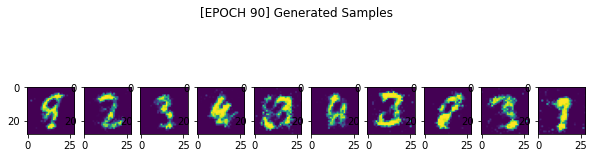

[EPOCH 91] SAMPLED G LOSS : 1.5523258447647095, SAMPLED D LOSS : 0.5397282838821411
[EPOCH 91] SAMPLED G LOSS : 1.2472504377365112, SAMPLED D LOSS : 0.5391977429389954
[EPOCH 92] SAMPLED G LOSS : 0.6722605228424072, SAMPLED D LOSS : 0.547982931137085
[EPOCH 92] SAMPLED G LOSS : 1.2254961729049683, SAMPLED D LOSS : 0.47674405574798584
[EPOCH 93] SAMPLED G LOSS : 1.0993602275848389, SAMPLED D LOSS : 0.5119088888168335
[EPOCH 93] SAMPLED G LOSS : 0.8980664014816284, SAMPLED D LOSS : 0.4996224045753479
[EPOCH 94] SAMPLED G LOSS : 0.7229762077331543, SAMPLED D LOSS : 0.5766081809997559
[EPOCH 94] SAMPLED G LOSS : 0.8829234838485718, SAMPLED D LOSS : 0.525944709777832
[EPOCH 95] SAMPLED G LOSS : 1.0576667785644531, SAMPLED D LOSS : 0.5279374122619629
[EPOCH 95] SAMPLED G LOSS : 1.0206091403961182, SAMPLED D LOSS : 0.4786016047000885
[EPOCH 96] SAMPLED G LOSS : 1.1386795043945312, SAMPLED D LOSS : 0.5032453536987305
[EPOCH 96] SAMPLED G LOSS : 0.9265167713165283, SAMPLED D LOSS : 0.5116474628

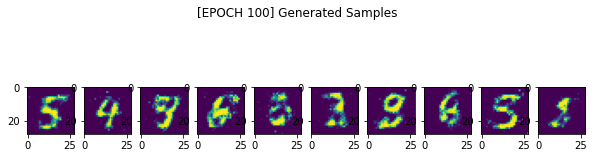

[EPOCH 101] SAMPLED G LOSS : 1.1966155767440796, SAMPLED D LOSS : 0.5312288403511047
[EPOCH 101] SAMPLED G LOSS : 0.9342923164367676, SAMPLED D LOSS : 0.5405998229980469
[EPOCH 102] SAMPLED G LOSS : 0.7994124889373779, SAMPLED D LOSS : 0.5281051993370056
[EPOCH 102] SAMPLED G LOSS : 1.1563998460769653, SAMPLED D LOSS : 0.5119615793228149
[EPOCH 103] SAMPLED G LOSS : 1.3312416076660156, SAMPLED D LOSS : 0.5487838983535767
[EPOCH 103] SAMPLED G LOSS : 1.2677377462387085, SAMPLED D LOSS : 0.4626924991607666
[EPOCH 104] SAMPLED G LOSS : 1.190563440322876, SAMPLED D LOSS : 0.5515289902687073
[EPOCH 104] SAMPLED G LOSS : 0.894290566444397, SAMPLED D LOSS : 0.48633873462677
[EPOCH 105] SAMPLED G LOSS : 1.0034303665161133, SAMPLED D LOSS : 0.4635527431964874
[EPOCH 105] SAMPLED G LOSS : 0.9726607203483582, SAMPLED D LOSS : 0.5343378186225891
[EPOCH 106] SAMPLED G LOSS : 1.0864759683609009, SAMPLED D LOSS : 0.4863578975200653
[EPOCH 106] SAMPLED G LOSS : 1.1940641403198242, SAMPLED D LOSS : 0.5

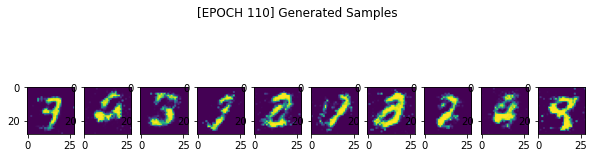

[EPOCH 111] SAMPLED G LOSS : 1.0384111404418945, SAMPLED D LOSS : 0.5411301851272583
[EPOCH 111] SAMPLED G LOSS : 1.1479907035827637, SAMPLED D LOSS : 0.5074954032897949
[EPOCH 112] SAMPLED G LOSS : 1.6296164989471436, SAMPLED D LOSS : 0.4779653251171112
[EPOCH 112] SAMPLED G LOSS : 1.1686491966247559, SAMPLED D LOSS : 0.48490869998931885
[EPOCH 113] SAMPLED G LOSS : 0.9231877326965332, SAMPLED D LOSS : 0.5045027732849121
[EPOCH 113] SAMPLED G LOSS : 1.0671114921569824, SAMPLED D LOSS : 0.49966397881507874
[EPOCH 114] SAMPLED G LOSS : 1.3998465538024902, SAMPLED D LOSS : 0.5327252745628357
[EPOCH 114] SAMPLED G LOSS : 1.331407904624939, SAMPLED D LOSS : 0.54212486743927
[EPOCH 115] SAMPLED G LOSS : 1.1475083827972412, SAMPLED D LOSS : 0.43915238976478577
[EPOCH 115] SAMPLED G LOSS : 1.0510685443878174, SAMPLED D LOSS : 0.4872191548347473
[EPOCH 116] SAMPLED G LOSS : 1.1417641639709473, SAMPLED D LOSS : 0.4999144971370697
[EPOCH 116] SAMPLED G LOSS : 1.012833595275879, SAMPLED D LOSS : 

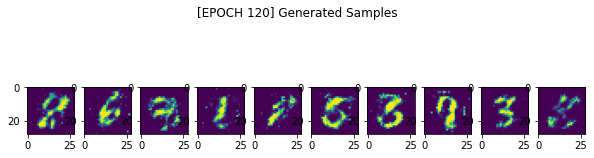

[EPOCH 121] SAMPLED G LOSS : 1.2148064374923706, SAMPLED D LOSS : 0.5334899425506592
[EPOCH 121] SAMPLED G LOSS : 0.716133713722229, SAMPLED D LOSS : 0.5490695238113403
[EPOCH 122] SAMPLED G LOSS : 0.8546190857887268, SAMPLED D LOSS : 0.5878649950027466
[EPOCH 122] SAMPLED G LOSS : 1.2133886814117432, SAMPLED D LOSS : 0.4649105370044708
[EPOCH 123] SAMPLED G LOSS : 0.6379170417785645, SAMPLED D LOSS : 0.5773016214370728
[EPOCH 123] SAMPLED G LOSS : 0.9914184212684631, SAMPLED D LOSS : 0.48077529668807983
[EPOCH 124] SAMPLED G LOSS : 0.8248858451843262, SAMPLED D LOSS : 0.5497723817825317
[EPOCH 124] SAMPLED G LOSS : 0.9473793506622314, SAMPLED D LOSS : 0.4760569930076599
[EPOCH 125] SAMPLED G LOSS : 1.2448631525039673, SAMPLED D LOSS : 0.5081056356430054
[EPOCH 125] SAMPLED G LOSS : 0.9952619075775146, SAMPLED D LOSS : 0.4816080927848816
[EPOCH 126] SAMPLED G LOSS : 1.0051484107971191, SAMPLED D LOSS : 0.5463768243789673
[EPOCH 126] SAMPLED G LOSS : 1.2712836265563965, SAMPLED D LOSS :

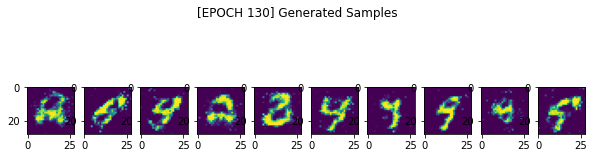

[EPOCH 131] SAMPLED G LOSS : 0.9397438764572144, SAMPLED D LOSS : 0.48663175106048584
[EPOCH 131] SAMPLED G LOSS : 1.044492483139038, SAMPLED D LOSS : 0.5242278575897217
[EPOCH 132] SAMPLED G LOSS : 1.7637159824371338, SAMPLED D LOSS : 0.5254828333854675
[EPOCH 132] SAMPLED G LOSS : 1.0403250455856323, SAMPLED D LOSS : 0.5089184045791626
[EPOCH 133] SAMPLED G LOSS : 0.939964771270752, SAMPLED D LOSS : 0.5631731152534485
[EPOCH 133] SAMPLED G LOSS : 1.2339673042297363, SAMPLED D LOSS : 0.4548816978931427
[EPOCH 134] SAMPLED G LOSS : 0.5591264963150024, SAMPLED D LOSS : 0.6875638961791992
[EPOCH 134] SAMPLED G LOSS : 1.1004159450531006, SAMPLED D LOSS : 0.4570443034172058
[EPOCH 135] SAMPLED G LOSS : 1.1923786401748657, SAMPLED D LOSS : 0.501455545425415
[EPOCH 135] SAMPLED G LOSS : 1.150360107421875, SAMPLED D LOSS : 0.4247703552246094
[EPOCH 136] SAMPLED G LOSS : 0.7774436473846436, SAMPLED D LOSS : 0.5620240569114685
[EPOCH 136] SAMPLED G LOSS : 1.0506136417388916, SAMPLED D LOSS : 0.

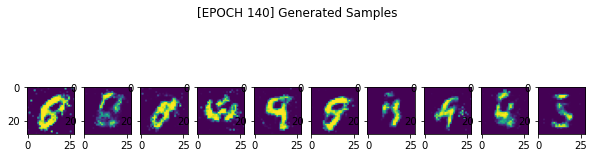

[EPOCH 141] SAMPLED G LOSS : 1.1778054237365723, SAMPLED D LOSS : 0.5324777364730835
[EPOCH 141] SAMPLED G LOSS : 1.1964967250823975, SAMPLED D LOSS : 0.46104544401168823
[EPOCH 142] SAMPLED G LOSS : 0.5402063727378845, SAMPLED D LOSS : 0.6476814150810242
[EPOCH 142] SAMPLED G LOSS : 1.002305507659912, SAMPLED D LOSS : 0.524734616279602
[EPOCH 143] SAMPLED G LOSS : 0.7780054807662964, SAMPLED D LOSS : 0.5885143280029297
[EPOCH 143] SAMPLED G LOSS : 0.7709333896636963, SAMPLED D LOSS : 0.5468757152557373
[EPOCH 144] SAMPLED G LOSS : 1.34468674659729, SAMPLED D LOSS : 0.5205460786819458
[EPOCH 144] SAMPLED G LOSS : 1.094186544418335, SAMPLED D LOSS : 0.4876481294631958
[EPOCH 145] SAMPLED G LOSS : 1.0333315134048462, SAMPLED D LOSS : 0.48503178358078003
[EPOCH 145] SAMPLED G LOSS : 0.9719878435134888, SAMPLED D LOSS : 0.5162923336029053
[EPOCH 146] SAMPLED G LOSS : 1.3327348232269287, SAMPLED D LOSS : 0.5097976326942444
[EPOCH 146] SAMPLED G LOSS : 1.2149569988250732, SAMPLED D LOSS : 0.

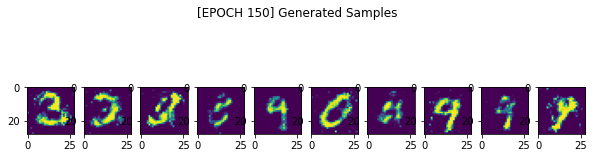

[EPOCH 151] SAMPLED G LOSS : 0.8932948708534241, SAMPLED D LOSS : 0.5182844400405884
[EPOCH 151] SAMPLED G LOSS : 1.1251044273376465, SAMPLED D LOSS : 0.5251204967498779
[EPOCH 152] SAMPLED G LOSS : 1.2531427145004272, SAMPLED D LOSS : 0.4827191233634949
[EPOCH 152] SAMPLED G LOSS : 1.2123476266860962, SAMPLED D LOSS : 0.5498714447021484
[EPOCH 153] SAMPLED G LOSS : 1.3764433860778809, SAMPLED D LOSS : 0.5787038803100586
[EPOCH 153] SAMPLED G LOSS : 1.318779706954956, SAMPLED D LOSS : 0.48941439390182495
[EPOCH 154] SAMPLED G LOSS : 1.0882065296173096, SAMPLED D LOSS : 0.45139026641845703
[EPOCH 154] SAMPLED G LOSS : 1.1048980951309204, SAMPLED D LOSS : 0.4809541702270508
[EPOCH 155] SAMPLED G LOSS : 1.5963903665542603, SAMPLED D LOSS : 0.5054988861083984
[EPOCH 155] SAMPLED G LOSS : 1.2110024690628052, SAMPLED D LOSS : 0.5185620784759521
[EPOCH 156] SAMPLED G LOSS : 1.011362075805664, SAMPLED D LOSS : 0.5018351078033447
[EPOCH 156] SAMPLED G LOSS : 1.2141194343566895, SAMPLED D LOSS :

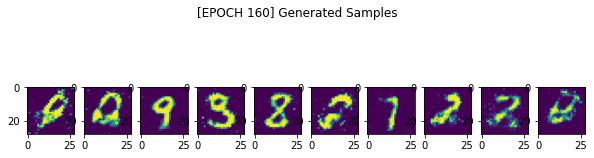

[EPOCH 161] SAMPLED G LOSS : 1.220902442932129, SAMPLED D LOSS : 0.4485042691230774
[EPOCH 161] SAMPLED G LOSS : 1.1471041440963745, SAMPLED D LOSS : 0.49933236837387085
[EPOCH 162] SAMPLED G LOSS : 1.0720727443695068, SAMPLED D LOSS : 0.5036426186561584
[EPOCH 162] SAMPLED G LOSS : 1.3201570510864258, SAMPLED D LOSS : 0.6020116806030273
[EPOCH 163] SAMPLED G LOSS : 1.0993093252182007, SAMPLED D LOSS : 0.5443540811538696
[EPOCH 163] SAMPLED G LOSS : 1.3191951513290405, SAMPLED D LOSS : 0.48796385526657104
[EPOCH 164] SAMPLED G LOSS : 1.0184414386749268, SAMPLED D LOSS : 0.493772953748703
[EPOCH 164] SAMPLED G LOSS : 1.0996453762054443, SAMPLED D LOSS : 0.5395497679710388
[EPOCH 165] SAMPLED G LOSS : 1.0512588024139404, SAMPLED D LOSS : 0.49680331349372864
[EPOCH 165] SAMPLED G LOSS : 1.4062657356262207, SAMPLED D LOSS : 0.48865920305252075
[EPOCH 166] SAMPLED G LOSS : 0.9680273532867432, SAMPLED D LOSS : 0.4807368516921997
[EPOCH 166] SAMPLED G LOSS : 1.8637373447418213, SAMPLED D LOSS

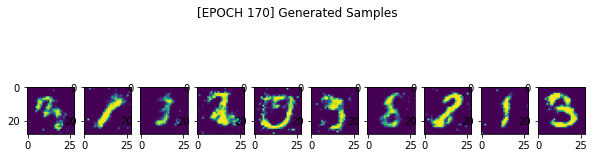

[EPOCH 171] SAMPLED G LOSS : 0.7854646444320679, SAMPLED D LOSS : 0.5295689105987549
[EPOCH 171] SAMPLED G LOSS : 1.2491531372070312, SAMPLED D LOSS : 0.4831249415874481
[EPOCH 172] SAMPLED G LOSS : 1.2812538146972656, SAMPLED D LOSS : 0.48294907808303833
[EPOCH 172] SAMPLED G LOSS : 1.336442232131958, SAMPLED D LOSS : 0.4688570499420166
[EPOCH 173] SAMPLED G LOSS : 0.8581209182739258, SAMPLED D LOSS : 0.5098973512649536
[EPOCH 173] SAMPLED G LOSS : 1.006185531616211, SAMPLED D LOSS : 0.5415574312210083
[EPOCH 174] SAMPLED G LOSS : 1.8498972654342651, SAMPLED D LOSS : 0.5764191746711731
[EPOCH 174] SAMPLED G LOSS : 1.2111130952835083, SAMPLED D LOSS : 0.5052765607833862
[EPOCH 175] SAMPLED G LOSS : 1.5582256317138672, SAMPLED D LOSS : 0.5281335115432739
[EPOCH 175] SAMPLED G LOSS : 1.0228536128997803, SAMPLED D LOSS : 0.5533204078674316
[EPOCH 176] SAMPLED G LOSS : 1.5547866821289062, SAMPLED D LOSS : 0.5157018303871155
[EPOCH 176] SAMPLED G LOSS : 0.8757199048995972, SAMPLED D LOSS : 

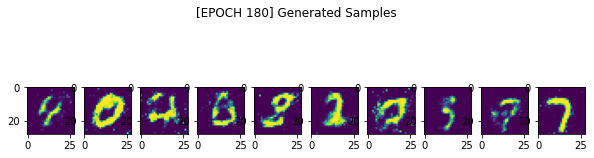

[EPOCH 181] SAMPLED G LOSS : 1.4447869062423706, SAMPLED D LOSS : 0.4213271141052246
[EPOCH 181] SAMPLED G LOSS : 1.6124801635742188, SAMPLED D LOSS : 0.5681397318840027
[EPOCH 182] SAMPLED G LOSS : 1.2036279439926147, SAMPLED D LOSS : 0.4524322748184204
[EPOCH 182] SAMPLED G LOSS : 1.4410243034362793, SAMPLED D LOSS : 0.5540244579315186
[EPOCH 183] SAMPLED G LOSS : 1.1228420734405518, SAMPLED D LOSS : 0.4798223376274109
[EPOCH 183] SAMPLED G LOSS : 1.2998323440551758, SAMPLED D LOSS : 0.4975585341453552
[EPOCH 184] SAMPLED G LOSS : 1.1937962770462036, SAMPLED D LOSS : 0.5177987813949585
[EPOCH 184] SAMPLED G LOSS : 1.3140087127685547, SAMPLED D LOSS : 0.5230583548545837
[EPOCH 185] SAMPLED G LOSS : 0.9571707844734192, SAMPLED D LOSS : 0.5213738679885864
[EPOCH 185] SAMPLED G LOSS : 1.2670363187789917, SAMPLED D LOSS : 0.48578453063964844
[EPOCH 186] SAMPLED G LOSS : 1.2266016006469727, SAMPLED D LOSS : 0.5484206676483154
[EPOCH 186] SAMPLED G LOSS : 0.9405168890953064, SAMPLED D LOSS 

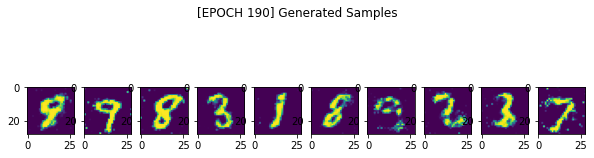

[EPOCH 191] SAMPLED G LOSS : 1.0674227476119995, SAMPLED D LOSS : 0.4518939256668091
[EPOCH 191] SAMPLED G LOSS : 1.3652520179748535, SAMPLED D LOSS : 0.5146421194076538
[EPOCH 192] SAMPLED G LOSS : 0.7781733274459839, SAMPLED D LOSS : 0.5336194038391113
[EPOCH 192] SAMPLED G LOSS : 1.5906308889389038, SAMPLED D LOSS : 0.4895687997341156
[EPOCH 193] SAMPLED G LOSS : 1.1187634468078613, SAMPLED D LOSS : 0.5592533349990845
[EPOCH 193] SAMPLED G LOSS : 1.1839507818222046, SAMPLED D LOSS : 0.4839630424976349
[EPOCH 194] SAMPLED G LOSS : 1.0456552505493164, SAMPLED D LOSS : 0.4663011133670807
[EPOCH 194] SAMPLED G LOSS : 1.0252550840377808, SAMPLED D LOSS : 0.4837478995323181
[EPOCH 195] SAMPLED G LOSS : 1.1553690433502197, SAMPLED D LOSS : 0.44232070446014404
[EPOCH 195] SAMPLED G LOSS : 0.9752818942070007, SAMPLED D LOSS : 0.5011780261993408
[EPOCH 196] SAMPLED G LOSS : 0.97298264503479, SAMPLED D LOSS : 0.5229173898696899
[EPOCH 196] SAMPLED G LOSS : 0.9083529710769653, SAMPLED D LOSS : 

In [ ]:
max_epoch = 200

for epoch in tqdm(range(max_epoch)):        
    for idx, sample in enumerate(train_dataloader):
        g_loss, d_loss = train(generator, discriminator, gen_optimizer, dis_optimizer, dim_z, sample)
        if idx % 200 == 0:
            print('[EPOCH {}] SAMPLED G LOSS : {}, SAMPLED D LOSS : {}'.format(epoch, g_loss, d_loss))

    if epoch % 10 == 0:
        fig, ax = plt.subplots(1, 10, figsize=(10, 3))
        for i in range(10):
            ax[i].imshow(test(generator, img_size, dim_z))
        plt.suptitle('[EPOCH {}] Generated Samples'.format(epoch))
        plt.pause(0.1)
        

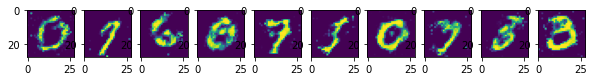

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(10, 3))
for i in range(10):
    ax[i].imshow(test(generator, img_size, dim_z))
